In [1]:
'''This Notebook generates Figure 2a-c for the MIST manuscript
    Also part of the overall flowchart in Figure 1
'''
import sys
import pandas as pd
sys.path.append("/Users/linhuaw/Documents/GitHub/MIST/")
import neighbors
import utils
import Data
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import scipy
scipy.__version__

'1.6.1'

In [3]:
# read data
melanoma = Data.Data(countpath="data/Melanoma/raw.csv", norm="cpm", radius=1.9)
mouse = Data.Data(countpath="data/MouseWT/raw.csv", norm="cpm", radius=1.9)

In [6]:
# read mouse spot meta data
mouse_meta = pd.read_csv("data/spot_metadata.tsv",sep="\t",index_col=0)

In [7]:
from sklearn.metrics import adjusted_rand_score, rand_score
def ARI_score(df):
    """Method to calculate adjusted rand index using sklearn function
        by comparing assigned spatial regions and the annotated meta info.
    """
    mouse_meta = pd.read_csv("/Users/linhuaw/Documents/AppSpatialGenes/spatialAD/spot_metadata.tsv",sep="\t",index_col=0)
    mouse_meta = mouse_meta.loc[mouse_meta.Group == "WT_12",:]
    mouse_meta["count_id"] = mouse_meta[["coord_X", "coord_Y"]].apply(lambda x: "x".join(x.astype(str)), axis=1)
    mouse_meta["region"] = mouse_meta["AT"]
    mouse_meta.loc[mouse_meta.Level_01 == "CX","region"] = "CX"
    mouse_meta = mouse_meta[["count_id", "region"]]
    mouse_meta.set_index("count_id", inplace=True, drop=True)
    df = df.loc[df["size"] > 5,:]
    mouse_meta = mouse_meta.loc[df.index,:]
    return adjusted_rand_score(mouse_meta.region.tolist(), df.cluster.tolist())

# Figure 2a, b, c

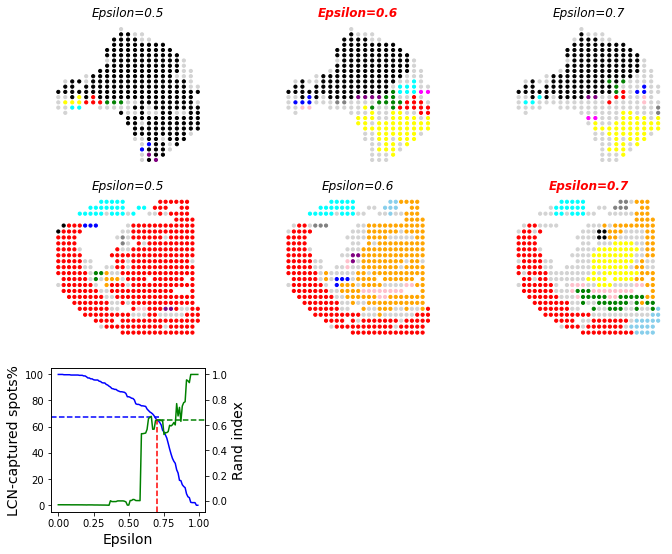

In [19]:
f, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 9))
eps = [0.5, 0.6, 0.7] # evaluating 3 parameters
mouse_df, mel2_df = None,None
# Figure 2a
for i in range(3):
    ep = eps[i] # Get region assignment for each of the epsilon value
    mousewt_ccs = neighbors.spatialCCs(mouse.nodes, mouse.cormat, ep, merge=0)
    df = neighbors.assign_membership(mousewt_ccs, mouse.meta)
    ### The color tuning in the following lines of code won't affect the results
    ### but to make the visualization colormap similar to the manual annotation
    df.loc[df["size"] == 1,"cluster"] = "lightgray"
    if ep == 0.5:
        df.loc[df["cluster"] == "orange", "cluster"] ="cyan"
        df.loc[df["cluster"] == "yellow", "cluster"] ="orange"
    if ep == 0.6:
        df.loc[df["cluster"] == "cyan", "cluster"] ="skyblue"
        df.loc[df["cluster"] == "yellow", "cluster"] ="cyan"
        df.loc[df["cluster"] == "red", "cluster"] ="black"
        df.loc[df["cluster"] == "orange", "cluster"] ="red"
        df.loc[df["cluster"] == "black", "cluster"] ="orange"
        df.loc[df["cluster"] == "green", "cluster"] ="pink"
    if ep == 0.7:
        df.loc[df["cluster"] == "purple", "cluster"] ="pink"
        df.loc[df["cluster"] == "cyan", "cluster"] ="skyblue"
        df.loc[df["cluster"] == "blue", "cluster"] ="cyan"
        df.loc[df["cluster"] == "orange", "cluster"] ="magenta"
        df.loc[df["cluster"] == "yellow", "cluster"] ="orange"
        df.loc[df["cluster"] == "magenta", "cluster"] ="yellow"
    if ep == 0.8:
        df.loc[df["cluster"] == "cyan", "cluster"] ="magenta"
        df.loc[df["cluster"] == "green", "cluster"] ="cyan"
        df.loc[df["cluster"] == "pink", "cluster"] ="green"
        df.loc[df["cluster"] == "magenta", "cluster"] ="pink"
        df.loc[df["cluster"] == "yellow", "cluster"] ="skyblue"
        df.loc[df["cluster"] == "blue", "cluster"] ="yellow"
    
    axs[1,i].scatter(x=df.x.to_numpy(), y=df.y.to_numpy(), c=df.cluster.tolist(), s=10)
    if ep == 0.7:
        axs[1,i].set_title("Epsilon=%.1f" %ep, color="red", fontweight='bold',style='italic')
        mouse_df = df.copy()
    else:
        axs[1,i].set_title("Epsilon=%.1f" %ep, color="black", style='italic')
    axs[1,i].invert_yaxis()
    axs[1,i].axis("off")
    
# Figure 2b 
for i in range(3):
    ep = eps[i]
    mel2_ccs = neighbors.spatialCCs(melanoma.nodes, melanoma.cormat, ep, merge=0)
    df = neighbors.assign_membership(mel2_ccs, melanoma.meta)
    ### The color tuning in the following lines of code won't affect the results
    ### but to make the visualization colormap similar to the manual annotation
    df.loc[df.cluster == "black", "cluster"] = "magenta"
    df.loc[df.cluster == "red", "cluster"] = "black"
    df.loc[df.cluster == "yellow", "cluster"] = "red"
    df.loc[df.cluster == "orange", "cluster"] = "yellow"
    df.loc[df["size"] == 1, "cluster"] = "lightgray"
    axs[0,i].scatter(x=df.x.to_numpy(), y=df.y.to_numpy(), c=df.cluster.tolist(), s=10)
    if ep == 0.6:
        axs[0,i].set_title("Epsilon=%.1f" %ep, color="red", fontweight='bold',style='italic')
        mel2_df = df.copy()
    else:
        axs[0,i].set_title("Epsilon=%.1f" %ep, color="black", style='italic')
    axs[0,i].invert_yaxis()
    axs[0,i].axis("off")
    
# Figure 2c
cc_explained_mouse, cc_explained_mel2 = [],[]
ari_mouse = []
for ep in np.arange(0,1, 0.01):
    mousewt_ccs = neighbors.spatialCCs(mouse.nodes, mouse.cormat, ep, merge=0)
    n1 = float(sum([len(cc) for cc in mousewt_ccs if len(cc) > 5]))
    cc_explained_mouse.append(n1/mouse.count.shape[0])
    df = neighbors.assign_membership(mousewt_ccs, mouse.meta)
    ari = ARI_score(df)
    ari_mouse.append(ari)
    mel2_ccs = neighbors.spatialCCs(melanoma.nodes, melanoma.cormat, ep, merge=0)
    n2 = float(sum([len(cc) for cc in mel2_ccs if len(cc) > 5]))
    cc_explained_mel2.append(n2/melanoma.count.shape[0])
    
axs[2,0].plot(np.arange(0,1, 0.01), np.multiply(cc_explained_mouse,100), color='blue')
axs[2,0].axvline(0.7, ymax=0.66, color='red', ls = "--")
axs[2,0].axhline(67, xmax=0.7, color='blue', ls = "--")

axs[2,0].set_xlabel("Epsilon", fontsize=14)
axs[2,0].set_ylabel("LCN-captured spots%", fontsize=14)
axs_ari = axs[2,0].twinx()
axs_ari.plot(np.arange(0,1, 0.01), ari_mouse, color = "green")
axs_ari.axhline(0.64, xmin=0.7, color='green', ls = "--")
axs_ari.set_ylabel("Rand index", fontsize=14)
axs[2,1].axis("off")
axs[2,2].axis("off")
f.subplots_adjust(wspace=0.5, hspace=0.2)

## Figure 1 - Augment random spots to CC

(3.75, 31.25, 32.0, 10.0)

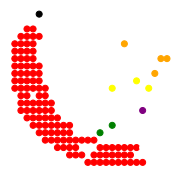

In [54]:
import numpy as np
df, _ = neighbors.assign_membreship(mousewt_ccs, mouse.meta)
red_spots = df.loc[df.cluster=="red",:].index.tolist()
rand_spots = np.random.choice(df.loc[df.cluster!="red",:].index.tolist(),20, replace=False).tolist()
df1 = df.loc[red_spots+rand_spots,:]
plt.figure(figsize=(3,3))
plt.scatter(x=df1.x.to_numpy(), y=df1.y.to_numpy(), c=df1.cluster.tolist())
plt.gca().invert_yaxis()
plt.axis("off")